In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [2]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA


In [3]:
import numpy as np
import pandas as pd

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

# Função OBV ajustada
def obv(group, smoothed_col):
    Volume = group['Volume']
    change = group[smoothed_col].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, Volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    return pd.Series(obv_values, index=group.index)


# Lista de parâmetros n para iterar
n_list = [12, 13, 14, 15, 16, 17, 18, 19, 20]  # Exemplo de diferentes valores de n
alpha = 0.20  # Mantemos um único valor de alpha

# Parâmetros adicionais
d = 10
e = 14

# Loop para cálculos por n
for n in n_list:
    smoothed_col = f'Smoothed_Close_{alpha:.2f}_n{n}'
    target_col = f'Prediction_{alpha:.2f}_n{n}'
    obv_col = f'OBV_{alpha:.2f}_n{n}'
    price_rate_col = f'Price_Rate_Of_Change_{alpha:.2f}_n{n}'
    macd_col = f'MACD_{alpha:.2f}_n{n}'
    macd_ema_col = f'MACD_EMA_{alpha:.2f}_n{n}'
    low_col = f'low_14_{alpha:.2f}_n{n}'
    high_col = f'high_14_{alpha:.2f}_n{n}'
    k_percent_col = f'k_percent_{alpha:.2f}_n{n}'
    r_percent_col = f'r_percent_{alpha:.2f}_n{n}'
    
    # Suavização exponencial
    price_data[smoothed_col] = price_data.groupby('Ticker')['Close'].transform(
        lambda x: exponential_smoothing(x.values, alpha)
    )
    
    # Target
    price_data[target_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: calculate_target(x, d)
    )
    
    # OBV
    obv_groups = price_data.groupby('Ticker').apply(lambda group: obv(group, smoothed_col))
    price_data[obv_col] = obv_groups.reset_index(level=0, drop=True)
    
    # Price Rate of Change
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: x.pct_change(periods=e)
    )
    
    # %R
    low_14 = price_data[['Ticker', 'Low']].copy()
    high_14 = price_data[['Ticker', 'High']].copy()
    low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=n).min())
    high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=n).max())
    r_percent = ((high_14 - price_data[smoothed_col]) / (high_14 - low_14)) * (-100)
    price_data[low_col] = low_14
    price_data[high_col] = high_14
    price_data[r_percent_col] = r_percent

    # %K    
    k_percent = ((price_data[smoothed_col] - low_14) / (high_14 - low_14)) * 100
    price_data[k_percent_col] = k_percent
    
    # MACD
    ema_26 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=26).mean())
    ema_12 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=12).mean())
    macd = ema_12 - ema_26
    ema_9_macd = macd.ewm(span=9).mean()
    price_data[macd_col] = macd
    price_data[macd_ema_col] = ema_9_macd

    # Calculando o Price Rate of Change (ROC) usando a coluna suavizada correspondente
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.pct_change(periods=e))


# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index


# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

# Visualização final
price_data.tail()


<ipython-input-3-de4cf52f9723>:155: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.20_n12,Prediction_0.20_n12,OBV_0.20_n12,Price_Rate_Of_Change_0.20_n12,low_14_0.20_n12,high_14_0.20_n12,r_percent_0.20_n12,k_percent_0.20_n12,MACD_0.20_n12,MACD_EMA_0.20_n12,Smoothed_Close_0.20_n13,Prediction_0.20_n13,OBV_0.20_n13,Price_Rate_Of_Change_0.20_n13,low_14_0.20_n13,high_14_0.20_n13,r_percent_0.20_n13,k_percent_0.20_n13,MACD_0.20_n13,MACD_EMA_0.20_n13,Smoothed_Close_0.20_n14,Prediction_0.20_n14,OBV_0.20_n14,Price_Rate_Of_Change_0.20_n14,low_14_0.20_n14,high_14_0.20_n14,r_percent_0.20_n14,k_percent_0.20_n14,MACD_0.20_n14,MACD_EMA_0.20_n14,Smoothed_Close_0.20_n15,Prediction_0.20_n15,OBV_0.20_n15,Price_Rate_Of_Change_0.20_n15,low_14_0.20_n15,high_14_0.20_n15,r_percent_0.20_n15,k_percent_0.20_n15,MACD_0.20_n15,MACD_EMA_0.20_n15,Smoothed_Close_0.20_n16,Prediction_0.20_n16,OBV_0.20_n16,Price_Rate_Of_Change_0.20_n16,low_14_0.20_n16,high_14_0.20_n16,r_percent_0.20_n16,k_percent_0.20_n16,MACD_0.20_n16,MACD_EMA_0.20_n16,Smoothed_Close_0.20_n17,Prediction_0.20_n17,OBV_0.20_n17,Price_Rate_Of_Change_0.20_n17,low_14_0.20_n17,high_14_0.20_n17,r_percent_0.20_n17,k_percent_0.20_n17,MACD_0.20_n17,MACD_EMA_0.20_n17,Smoothed_Close_0.20_n18,Prediction_0.20_n18,OBV_0.20_n18,Price_Rate_Of_Change_0.20_n18,low_14_0.20_n18,high_14_0.20_n18,r_percent_0.20_n18,k_percent_0.20_n18,MACD_0.20_n18,MACD_EMA_0.20_n18,Smoothed_Close_0.20_n19,Prediction_0.20_n19,OBV_0.20_n19,Price_Rate_Of_Change_0.20_n19,low_14_0.20_n19,high_14_0.20_n19,r_percent_0.20_n19,k_percent_0.20_n19,MACD_0.20_n19,MACD_EMA_0.20_n19,Smoothed_Close_0.20_n20,Prediction_0.20_n20,OBV_0.20_n20,Price_Rate_Of_Change_0.20_n20,low_14_0.20_n20,high_14_0.20_n20,r_percent_0.20_n20,k_percent_0.20_n20,MACD_0.20_n20,MACD_EMA_0.20_n20,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
11763,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.990622,-1.0,2163837770,-0.055584,53.330002,57.680000,-61.824820,38.175180,-1.092991,-0.932553,54.990622,-1.0,2163837770,-0.055584,53.330002,59.590000,-73.472521,26.527479,-1.092991,-0.932553,54.990622,-1.0,2163837770,-0.055584,53.330002,59.939999,-74.877148,25.122852,-1.092991,-0.932553,54.990622,-1.0,2163837770,-0.055584,53.330002,60.189999,-75.792704,24.207296,-1.092991,-0.932553,54.990622,-1.0,2163837770,-0.055584,53.330002,60.189999,-75.792704,24.207296,-1.092991,-0.932553,54.990622,-1.0,2163837770,-0.055584,53.330002,60.189999,-75.792704,24.207296,-1.092991,-0.932553,54.990622,-1.0,2163837770,-0.055584,53.330002,60.189999,-75.792704,24.207296,-1.092991,-0.932553,54.990622,-1.0,2163837770,-0.055584,53.330002,60.189999,-75.792704,24.207296,-1.092991,-0.932553,54.990622,-1.0,2163837770,-0.055584,53.330002,60.189999,-75.792704,24.207296,-1.092991,-0.932553,0.299999,0.0,34.856388,54.250000,-1.0,52.669998
11764,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,54.640498,-1.0,2140229070,-0.066544,52.880001,56.709999,-54.034010,45.965990,-1.130935,-0.972229,54.640498,-1.0,2140229070,-0.066544,52.880001,57.680000,-63.322983,36.677017,-1.130935,-0.972229,54.640498,-1.0,2140229070,-0.066544,52.880001,59.590000,-73.763089,26.236911,-1.130935,-0.972229,54.640498,-1.0,2140229070,-0.066544,52.880001,59.939999,-75.063780,24.936220,-1.130935,-0.972229,54.640498,-1.0,2140229070,-0.066544,52.880001,60.189999,-75.916592,24.083408,-1.130935,-0.972229,54.640498,-1.0,2140229070,-0.066544,52.880001,60.189999,-75.916592,24.083408,-1.130935,-0.972229,54.640498,-1.0,2140229070,-0.066544,52.880001,60.189999,-75.916592,24.083408,-1.130935,-0.972229,54.640498,-1.0,2140229070,-0.066544,52.880001,60.189999,-75.916592,24.083408,-1.130935,-0.972229,54.640498,-1.0,2140229070,-0.066544,52.880001,60.189999,-75.916592,24.083408,-1.130935,-0.972229,1.009998,0.0,29.783645,53.240002,1.0,54.490002
11765,2025-01-06,53.480000,53.790001,52.480000,52.560001,52.560001,21689500,VALE3.SA,-0.680000,54.224398,-1.0,2118539570,-0.074615,52.4800

In [4]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.20_n12,Prediction_0.20_n12,OBV_0.20_n12,Price_Rate_Of_Change_0.20_n12,low_14_0.20_n12,high_14_0.20_n12,r_percent_0.20_n12,k_percent_0.20_n12,MACD_0.20_n12,MACD_EMA_0.20_n12,Smoothed_Close_0.20_n13,Prediction_0.20_n13,OBV_0.20_n13,Price_Rate_Of_Change_0.20_n13,low_14_0.20_n13,high_14_0.20_n13,r_percent_0.20_n13,k_percent_0.20_n13,MACD_0.20_n13,MACD_EMA_0.20_n13,Smoothed_Close_0.20_n14,Prediction_0.20_n14,OBV_0.20_n14,Price_Rate_Of_Change_0.20_n14,low_14_0.20_n14,high_14_0.20_n14,r_percent_0.20_n14,k_percent_0.20_n14,MACD_0.20_n14,MACD_EMA_0.20_n14,Smoothed_Close_0.20_n15,Prediction_0.20_n15,OBV_0.20_n15,Price_Rate_Of_Change_0.20_n15,low_14_0.20_n15,high_14_0.20_n15,r_percent_0.20_n15,k_percent_0.20_n15,MACD_0.20_n15,MACD_EMA_0.20_n15,Smoothed_Close_0.20_n16,Prediction_0.20_n16,OBV_0.20_n16,Price_Rate_Of_Change_0.20_n16,low_14_0.20_n16,high_14_0.20_n16,r_percent_0.20_n16,k_percent_0.20_n16,MACD_0.20_n16,MACD_EMA_0.20_n16,Smoothed_Close_0.20_n17,Prediction_0.20_n17,OBV_0.20_n17,Price_Rate_Of_Change_0.20_n17,low_14_0.20_n17,high_14_0.20_n17,r_percent_0.20_n17,k_percent_0.20_n17,MACD_0.20_n17,MACD_EMA_0.20_n17,Smoothed_Close_0.20_n18,Prediction_0.20_n18,OBV_0.20_n18,Price_Rate_Of_Change_0.20_n18,low_14_0.20_n18,high_14_0.20_n18,r_percent_0.20_n18,k_percent_0.20_n18,MACD_0.20_n18,MACD_EMA_0.20_n18,Smoothed_Close_0.20_n19,Prediction_0.20_n19,OBV_0.20_n19,Price_Rate_Of_Change_0.20_n19,low_14_0.20_n19,high_14_0.20_n19,r_percent_0.20_n19,k_percent_0.20_n19,MACD_0.20_n19,MACD_EMA_0.20_n19,Smoothed_Close_0.20_n20,Prediction_0.20_n20,OBV_0.20_n20,Price_Rate_Of_Change_0.20_n20,low_14_0.20_n20,high_14_0.20_n20,r_percent_0.20_n20,k_percent_0.20_n20,MACD_0.20_n20,MACD_EMA_0.20_n20,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
5733,2025-01-02,11.72,11.89,11.49,11.60,11.60,33417900,ABEV3.SA,-0.139999,12.232996,-1.0,-2565304547,-0.106219,11.49,13.58,-64.449940,35.550060,-0.117013,0.027268,12.232996,-1.0,-2565304547,-0.106219,11.49,14.36,-74.111626,25.888374,-0.117013,0.027268,12.232996,-1.0,-2565304547,-0.106219,11.49,14.50,-75.315739,24.684261,-0.117013,0.027268,12.232996,-1.0,-2565304547,-0.106219,11.49,14.50,-75.315739,24.684261,-0.117013,0.027268,12.232996,-1.0,-2565304547,-0.106219,11.49,14.53,-75.559332,24.440668,-0.117013,0.027268,12.232996,-1.0,-2565304547,-0.106219,11.49,14.53,-75.559332,24.440668,-0.117013,0.027268,12.232996,-1.0,-2565304547,-0.106219,11.49,14.53,-75.559332,24.440668,-0.117013,0.027268,12.232996,-1.0,-2565304547,-0.106219,11.49,14.53,-75.559332,24.440668,-0.117013,0.027268,12.232996,-1.0,-2565304547,-0.106219,11.49,14.53,-75.559332,24.440668,-0.117013,0.027268,0.139999,0.00,24.358052,11.60,-1.0,11.08
5734,2025-01-03,11.49,11.55,11.27,11.33,11.33,41365900,ABEV3.SA,-0.270000,12.052397,-1.0,-2606670447,-0.126855,11.27,13.42,-63.609464,36.390536,-0.169565,-0.012098,12.052397,-1.0,-2606670447,-0.126855,11.27,13.58,-66.130019,33.869981,-0.169565,-0.012098,12.052397,-1.0,-2606670447,-0.126855,11.27,14.36,-74.679722,25.320278,-0.169565,-0.012098,12.052397,-1.0,-2606670447,-0.126855,11.27,14.50,-75.777198,24.222802,-0.169565,-0.012098,12.052397,-1.0,-2606670447,-0.126855,11.27,14.50,-75.777198,24.222802,-0.169565,-0.012098,12.052397,-1.0,-2606670447,-0.126855,11.27,14.53,-76.000106,23.999894,-0.169565,-0.012098,12.052397,-1.0,-2606670447,-0.126855,11.27,14.53,-76.000106,23.999894,-0.169565,-0.012098,12.052397,-1.0,-2606670447,-0.126855,11.27,14.53,-76.000106,23.999894,-0.169565,-0.012098,12.052397,-1.0,-2606670447,-0.126855,11.27,14.53,-76.000106,23.999894,-0.169565,-0.012098,0.270000,0.00,21.470777,11.33,-1.0,11.09
5735,2025-01-06,11.36,11.50,11.21,11.29,11.29,50881500,ABEV3.SA,-0.040000,11.899917,-1.0,-2657551947,-0.137859,11.21,13.42,-68.782017,31.217983,-0.220969,-0.053872,11.899917,-1.0,-2657551947,-0.137859,11.21,13.42,-68.782017,31.217983,-0.220969,-0.053872,11.899917,-1.0,-2657551947,-0.137859,11.21,13.58,-70.889559,29.110441,-0.2

n: 12
Fold 1:
 - Correct Prediction (y_test): 47.85%
 - Correct Prediction (Verify): 48.27%
Fold 2:
 - Correct Prediction (y_test): 52.26%
 - Correct Prediction (Verify): 51.10%
Fold 3:
 - Correct Prediction (y_test): 58.03%
 - Correct Prediction (Verify): 46.48%
Fold 4:
 - Correct Prediction (y_test): 61.91%
 - Correct Prediction (Verify): 56.87%
Fold 5:
 - Correct Prediction (y_test): 54.14%
 - Correct Prediction (Verify): 47.22%
Média de acurácia (y_test) para n 12: 54.84%
Média de acurácia (Verify) para n 12: 49.99%
---
n: 13
Fold 1:
 - Correct Prediction (y_test): 48.79%
 - Correct Prediction (Verify): 48.58%
Fold 2:
 - Correct Prediction (y_test): 54.35%
 - Correct Prediction (Verify): 52.36%
Fold 3:
 - Correct Prediction (y_test): 58.87%
 - Correct Prediction (Verify): 47.11%
Fold 4:
 - Correct Prediction (y_test): 58.87%
 - Correct Prediction (Verify): 55.30%
Fold 5:
 - Correct Prediction (y_test): 54.77%
 - Correct Prediction (Verify): 47.64%
Média de acurácia (y_test) para n 

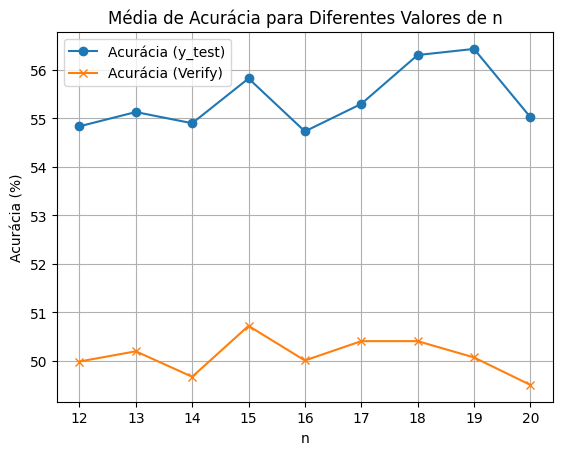

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

# Loop para cada n em n_list e realização de validação cruzada em série temporal
for n in n_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}_n{n}',
                    f'r_percent_{alpha:.2f}_n{n}',
                    f'Price_Rate_Of_Change_{alpha:.2f}_n{n}',
                    f'MACD_{alpha:.2f}_n{n}',
                    f'MACD_EMA_{alpha:.2f}_n{n}',
                    f'OBV_{alpha:.2f}_n{n}']]
    y = price_data[f'Prediction_{alpha:.2f}_n{n}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()


#### Caso apareça erro float 32

n: 2
Fold 1:
 - Correct Prediction (y_test): 41.99%
 - Correct Prediction (Verify): 41.77%
Fold 2:
 - Correct Prediction (y_test): 46.37%
 - Correct Prediction (Verify): 47.12%
Fold 3:
 - Correct Prediction (y_test): 53.85%
 - Correct Prediction (Verify): 53.31%
Fold 4:
 - Correct Prediction (y_test): 49.04%
 - Correct Prediction (Verify): 49.68%
Fold 5:
 - Correct Prediction (y_test): 49.15%
 - Correct Prediction (Verify): 47.76%
Média de acurácia (y_test) para n 2: 48.08%
Média de acurácia (Verify) para n 2: 47.93%
---
n: 4
Fold 1:
 - Correct Prediction (y_test): 48.16%
 - Correct Prediction (Verify): 47.85%
Fold 2:
 - Correct Prediction (y_test): 47.74%
 - Correct Prediction (Verify): 49.00%
Fold 3:
 - Correct Prediction (y_test): 50.58%
 - Correct Prediction (Verify): 50.68%
Fold 4:
 - Correct Prediction (y_test): 51.52%
 - Correct Prediction (Verify): 51.63%
Fold 5:
 - Correct Prediction (y_test): 46.07%
 - Correct Prediction (Verify): 45.65%
Média de acurácia (y_test) para n 4: 4

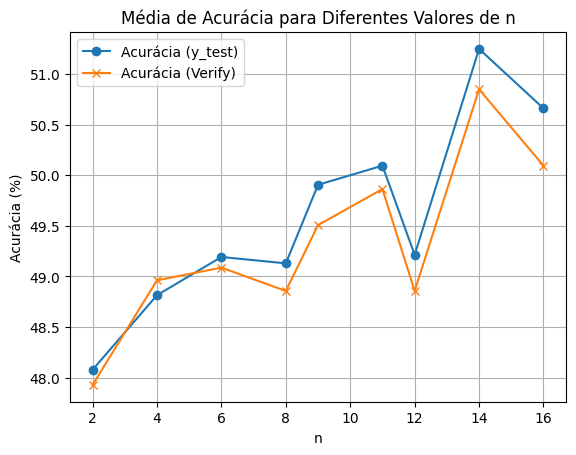

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

for n in n_list:
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}_n{n}',
                    f'r_percent_{alpha:.2f}_n{n}',
                    f'Price_Rate_Of_Change_{alpha:.2f}_n{n}',
                    f'MACD_{alpha:.2f}_n{n}',
                    f'MACD_EMA_{alpha:.2f}_n{n}',
                    f'OBV_{alpha:.2f}_n{n}']]
    y = price_data[f'Prediction_{alpha:.2f}_n{n}']
    verify = price_data['Verify']

    # Concatenar e tratar NaN
    data = pd.concat([X, y, verify], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]


    # Converter para float32
    X = X.astype(np.float32)

    # Configurar TimeSeriesSplit e o resto do código
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()